In [1]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
from six.moves import xrange

import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time as ti
import csv
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from pympler import asizeof
import time as ti
from PIL import Image
import scipy.misc

/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
image_size = 64
image_shape = [image_size, image_size, 3]

In [4]:
img_width, img_height = 64, 64
data_dir = '../face_data_test_ic'
learning_rate= 0.0002
beta1= 0.5
batch_size=64

In [5]:
alpha = 0.2
lambda_val = 0.001

In [6]:
def preprocessing(image):
    return image/127.5 - 1;

In [7]:
def minibatch_discrimination(input_tensor, name, num_kernels=100, kernel_dim=5):
    with tf.variable_scope(name) as scope:
        input_shape = input_tensor.get_shape().as_list()
        print "input-shape" , input_shape
        batch_size = input_shape[0]
        print batch_size
        features = input_shape[1]
        print features
        W = tf.get_variable("weight", [features, num_kernels * kernel_dim], initializer=tf.contrib.layers.xavier_initializer())
        bias = tf.get_variable("bias", [num_kernels], initializer=tf.constant_initializer(0.0))
        activation = tf.matmul(input_tensor,W)
        print activation.get_shape()
        activation = tf.reshape(activation,[-1,num_kernels,kernel_dim])
        a1 = tf.expand_dims(activation, 3)
        a2 = tf.transpose(activation, perm=[1,2,0])
        a2 = tf.expand_dims(a2, 0)
        abs_diff = tf.reduce_sum(tf.abs(a1 - a2), reduction_indices=[2])
        expsum  = tf.reduce_sum(tf.exp(-abs_diff), reduction_indices=[2])
        expsum = expsum + bias
        print expsum.get_shape()
        return tf.concat([input_tensor,expsum],axis=1)

def gaussian_noise_layer(input_tensor, std=0.2):
    noise = tf.random_normal(shape=tf.shape(input_tensor), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_tensor + noise

def lrelu(x,alpha=0.2):
    return tf.maximum(x, alpha*x)


# In[4]:

def linear(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        weights = tf.get_variable("weights", [input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=math.sqrt(3.0 / (input_dim + output_dim))))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        return tf.matmul(input_tensor, weights) + bias 


# In[5]:

def conv_2d(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5,input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, kernel, strides=[1, 2, 2, 1],padding='SAME')
        return conv+bias


# In[6]:

def conv_2dtranspose(input_tensor, input_dim, output_shape,name=None):
    output_dim=output_shape[-1]
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5, output_dim, input_dim], initializer=tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        deconv = tf.nn.conv2d_transpose(input_tensor, kernel, output_shape=output_shape, strides=[1, 2, 2, 1],padding='SAME')
        return deconv+bias


# In[7]:

def batch_norm(input_tensor,name,is_train=True):
    return tf.contrib.layers.batch_norm(input_tensor,decay=0.9, updates_collections=None, epsilon=1e-5, scale=True,    
                                        is_training=is_train, scope=name)


In [8]:
load_img_datagen = ImageDataGenerator(preprocessing_function = preprocessing)
img_input = load_img_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None)

Found 21709 images belonging to 1 classes.


In [9]:
def generator(z):
#    z = tf.placeholder(tf.float32, [None, 100], name='z')
    l1=linear(input_tensor=z,name="g_lin", input_dim=100, output_dim=1024*4*4)  
    l2= tf.reshape(l1, [-1, 4, 4, 1024])
    l3 = lrelu(batch_norm(input_tensor=l2,name="g_bn0"))
    print l3
    #conv1
    l4=conv_2dtranspose(input_tensor=l3,name="g_c2dt1",input_dim=1024,output_shape=[batch_size,8,8,512])
    l5=lrelu(batch_norm(input_tensor=l4,name="g_bn1"))
    print l5
    #conv2
    l6=conv_2dtranspose(input_tensor=l5,name="g_c2dt2",input_dim=512,output_shape=[batch_size,16,16,256])
    l7=lrelu(batch_norm(input_tensor=l6,name='g_bn2'))
    print l7
    #conv3
    l8=conv_2dtranspose(input_tensor=l7,name='g_c2dt3',input_dim=256,output_shape=[batch_size,32,32,128])
    l9=lrelu(batch_norm(input_tensor=l8,name='g_bn3'))
    print l9
    #conv4
    l10=conv_2dtranspose(input_tensor=l9,name='g_c2dt4',input_dim=128,output_shape=[batch_size,64,64,3])
    l11=tf.nn.tanh(l10)
    print l11
    return l11

In [10]:
def discriminator(images, reuse=False, alpha=0.2):
     with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
            
        #naming of the layers is as per layer number    
        #h0 conv2d no batch_norm
        images = gaussian_noise_layer(images)
        l1 = conv_2d(input_tensor=images, input_dim=3, output_dim= 64, name='d_c2d0')
        l2 = lrelu(l1,alpha)

        #h1 conv2d with batch_norm
        l3 = conv_2d(input_tensor=l2, input_dim=64, output_dim=64*2, name='d_c2d1')
        l4 = batch_norm(input_tensor=l3,name="d_bn1")
        l5 = lrelu(l4,alpha)

        #h2 conv2d with batch_norm
        l6 = conv_2d(input_tensor=l5, input_dim=64*2, output_dim=64*4, name='d_c2d2')
        l7 = batch_norm(input_tensor=l6,name="d_bn2")
        l8 = lrelu(l7,alpha)

        #h3 conv2d with batch_norm
        l9 = conv_2d(input_tensor=l8, input_dim=64*4, output_dim=64*8, name='d_c2d3')
        l10 = batch_norm(input_tensor=l9,name="d_bn3")
        l11 = lrelu(l10,alpha)

        #h4 reshape and linear
        l12 = tf.reshape(l11, [-1, 8192]) #l12 = tf.reshape(l11, [32, -1]) #l12 = tf.reshape(l11, [64, -1])
        l13 = minibatch_discrimination(l12,name="d_mini",num_kernels=100)
        print l13.get_shape()
        input_dim_linear = l13.get_shape().as_list()
        l14 = linear(input_tensor=l13, input_dim=input_dim_linear[1], output_dim=1, name="d_lin4")
        print l14.get_shape().as_list()
        #sigmoid
        #minibatch discrimination layer

        l15 = tf.nn.sigmoid(l14)
        print l15
        return l15, l14


In [11]:
z = tf.placeholder(tf.float32, [None, 100], name='z')
G = generator(z)

Tensor("Maximum:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("Maximum_1:0", shape=(64, 8, 8, 512), dtype=float32)
Tensor("Maximum_2:0", shape=(64, 16, 16, 256), dtype=float32)
Tensor("Maximum_3:0", shape=(64, 32, 32, 128), dtype=float32)
Tensor("Tanh:0", shape=(64, 64, 64, 3), dtype=float32)


In [12]:
images = tf.placeholder(
            tf.float32, [None] + image_shape, name='real_images')

In [13]:
D1, D1_logits = discriminator(images, False, alpha)

input-shape [None, 8192]
None
8192
(?, 500)
(?, 100)
(?, 8292)
[None, 1]
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)


In [14]:
D2, D2_logits = discriminator(G, True, alpha)

input-shape [64, 8192]
64
8192
(64, 500)
(64, 100)
(64, 8292)
[64, 1]
Tensor("discriminator_1/Sigmoid:0", shape=(64, 1), dtype=float32)


In [15]:
t_vars=tf.trainable_variables()
discrim_vars = [var for var in t_vars if 'd_' in var.name]
gen_vars = [var for var in t_vars if 'g_' in var.name]

In [16]:
discrim_loss_real_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits, labels=tf.scalar_mul(0.9,tf.ones_like(D1_logits))))
discrim_loss_fake_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.zeros_like(D2_logits)))
discrim_loss = discrim_loss_real_img + discrim_loss_fake_img
gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.ones_like(D2_logits)))

In [17]:
discrim_vars

In [18]:
dopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(discrim_loss, var_list=discrim_vars)
gopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)

In [19]:
saver = tf.train.Saver()

In [20]:
def load(checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        return True
    else:
        return False

In [21]:
sess = tf.InteractiveSession()
isLoaded = load('models/')

 [*] Reading checkpoints...


In [22]:
isLoaded

True

In [23]:
mask = tf.placeholder(tf.float32, [None] + image_shape, name='mask')

In [24]:
imp_matrix = tf.placeholder(tf.float32, [None] + image_shape, name='imp_matrix')

In [25]:
contextual_loss = tf.reduce_sum(
    tf.contrib.layers.flatten(
        tf.multiply(tf.abs(tf.multiply(tf.cast(mask,tf.float32), tf.cast(G,tf.float32)) - tf.multiply(tf.cast(mask,tf.float32), tf.cast(images, tf.float32))),tf.cast(imp_matrix, tf.float32))), 1)

In [26]:
perceptual_loss = gen_loss
complete_loss = contextual_loss + lambda_val*perceptual_loss
grad_complete_loss = tf.gradients(complete_loss, z)

In [27]:
#get input image y
real_images=next(img_input)

In [28]:
batch_images = np.array(real_images).astype(np.float32)

In [29]:
img = (real_images[1,:,:,:] +1.)/2
plt.imshow(img)

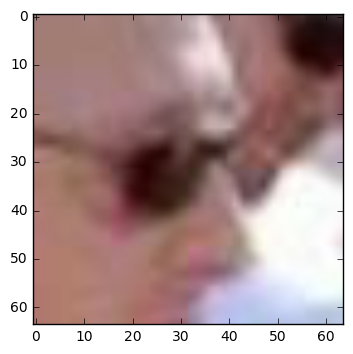

In [30]:
plt.axis('on')
plt.show()

In [31]:
config = {}

In [32]:
config['maskType'] = 'center'

In [33]:
config['learning_rate'] = 0.01

In [34]:
config['momentum'] = 0.9

In [35]:
#get mask M
if config['maskType'] == 'random':
    fraction_masked = 0.2
    mask_ = np.ones(image_shape)
    mask_[np.random.random(image_shape[:2]) < fraction_masked] = 0.0
elif config['maskType'] == 'center':
    scale = 0.25
    #assert(scale <= 0.5)
    mask_ = np.ones(image_shape)
    sz = image_size
    l = int(image_size*scale)
    u = int(image_size*(1.0-scale))
    mask_[l:u, l:u, :] = 0.0
elif config['maskType'] == 'left':
    mask_ = np.ones(image_shape)
    c = image_size // 2
    mask_[:,:c,:] = 0.0
elif config['maskType'] == 'full':
    mask_ = np.ones(image_shape)
else:
    assert(False)

In [36]:
def merge_images(image_batch, size):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im
    return img

In [37]:
config

{'learning_rate': 0.01, 'maskType': 'center', 'momentum': 0.9}

In [38]:
#create the importance matrix

a=np.ones((64,64))
n=64
for k in range(1,16):
    for i in range(k,n-k):
        for j in range(k,n-k):
            a[i,j]+=1

scale=0.25
image_size=64
sz = image_size
l = int(image_size*scale)
u = int(image_size*(1.0-scale))
a[l:u, l:u] = 0.0

non_zero_mean = np.sum(a)/(32*32)

importance_matrix = a/32#non_zero_mean

In [39]:
#batch_images = ...
batch_mask = np.resize(mask_, [batch_size] + image_shape)
imp_mask = np.resize(importance_matrix, [batch_size] + image_shape)
zhats = np.random.uniform(-1, 1, size=(batch_size, 100))

vel = 0
for i in xrange(5000):
    fd = {
        z: zhats,
        imp_matrix: imp_mask,
        mask: batch_mask,
        images: batch_images,
    }
    run = [complete_loss, grad_complete_loss, G]
    loss, g, G_imgs = sess.run(run, feed_dict=fd)
    
    if (i%500 is 0):
        print "loss in iteration: " + str(i) + " is: " + str(np.mean(loss))

    prev_vel = np.copy(vel)
    vel = config['momentum']*vel - config['learning_rate']*g[0]
    zhats += -config['momentum'] * prev_vel + (1+config['momentum'])*vel
    zhats = np.clip(zhats, -1, 1)

loss in iteration: 0 is: 823.797
loss in iteration: 500 is: 273.434
loss in iteration: 1000 is: 257.18
loss in iteration: 1500 is: 251.654
loss in iteration: 2000 is: 257.315
loss in iteration: 2500 is: 249.093
loss in iteration: 3000 is: 258.956
loss in iteration: 3500 is: 260.007
loss in iteration: 4000 is: 260.605
loss in iteration: 4500 is: 261.574


In [40]:
np.mean(loss)

248.69696

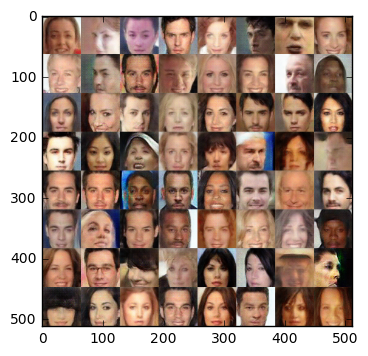

In [41]:
created_images = (G_imgs + 1.)/2
im = merge_images(created_images, [8,8])
plt.imshow(im)
plt.axis('on')
plt.show()

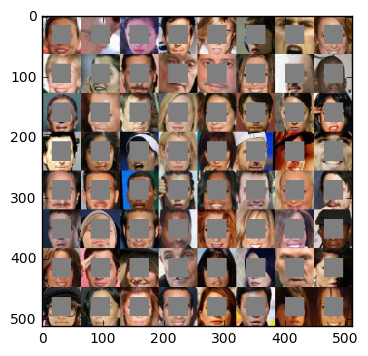

In [42]:
masked_images = np.multiply(batch_images, batch_mask)
input_images = (masked_images + 1.)/2
im = merge_images(input_images, [8,8])
plt.imshow(im)
plt.axis('on')
plt.show()

In [43]:
inv_mask_ = 1- mask_

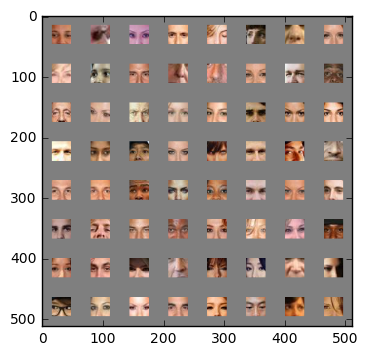

In [44]:
inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(batch_images, inv_batch_mask)

inv_input_images = (inv_masked_images + 1.)/2
im_ = merge_images(inv_input_images, [8,8])
plt.imshow(im_)
plt.axis('on')
plt.show()

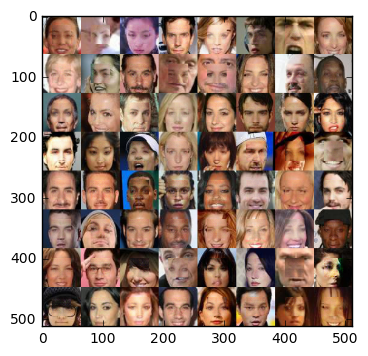

In [45]:
inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(G_imgs, inv_batch_mask)

Recons_img = inv_masked_images + masked_images

rec_images = (Recons_img + 1.)/2
im_r = merge_images(rec_images, [8,8])
plt.imshow(im_r)
plt.axis('on')
plt.show()